# Investigation of Public WasteWater Sequences

The following code chunk loads the required packages and defines some helper functions.

In [1]:
suppressPackageStartupMessages({
    library(dplyr)
    library(here)
    library(ggplot2)
    theme_set(theme_bw())
    library(lubridate)
    library(provoc)
    library(tictoc)
})
full_varmat <- astronomize(path = here("../../constellations/constellations/definitions"))

# Loads by Bioproject Accession Number.
# runtables must already be downloaded.
load_prj <- function(prj) {
    read.csv(here("data", "runtables",
        paste0("SraRunTable_", prj, ".txt")))
}

# Removes columns with only one unique value
rm_ones <- function(prj_df) {
    ones <- apply(prj_df, 2, function(x) length(unique(x))) == 1
    ones[names(prj_df) == "BioProject"] <- FALSE
    prj_df <- prj_df[!ones]
    prj_df
}

# Visually tests for temporal regularity in sampling
diff_dates <- function(df, col = "wwtp", plot = TRUE, ...) {
    tmp <- bind_rows(lapply(unique(df[, col]), function(x) {
        n <- sum(df[, col] == x)
        thisdate <- ymd(df$Collection_Date[df[, col] == x])
        tmp <- data.frame(
            wwtp = x,
            diffs = as.numeric(diff(sort(ymd(thisdate)))),
            date_low = sort(thisdate)[1:(n - 1)],
            date_high = sort(thisdate)[2:n]
        )
        tmp$mean_date <- as.Date(
            as.numeric(as.Date(tmp$date_low)) / 2 +
                as.numeric(as.Date(tmp$date_high)) / 2,
            origin = "1970-01-01")
        tmp
    }))

    if (plot) {
        plot(x = as.Date(df$Collection_Date), 
            y = as.factor(df[, col]), pch = "|", 
            yaxt = "n", cex = 2, ...)
        yticks <- rev(unique(as.numeric(as.factor(df[, col]))))
        axis(2, at = yticks, labels = sort(levels(as.factor(df[, col]))))
        text(x = tmp[, "mean_date"],
            y = as.numeric(as.factor(tmp[, "wwtp"])),
            labels = tmp[, "diffs"])
        return(invisible())
    } else {
        return(tmp)
    }
}

# Also tests for temporal regularity
table_regularity <- function(dates, wwtps, mindays = 1) {
    t1 <- table(wwtps, dates)
    t1 <- t1[, order(colnames(t1))]
    ismin <- apply(t1, 2, function(x) sum(x > 0) >= mindays)
    t1 <- t1[, ismin]
    colnames(t1) <- c(0, diff(as.numeric(ymd(colnames(t1)))))
    t1
}

### Baaijens - PRJNA741211

These particular data are from New Haven, Connecticut.

In [2]:
baaijens <- load_prj("PRJNA741211")
baaijens <- rm_ones(baaijens) 
head(baaijens)

,Run,Bases,BioProject,BioSample,Bytes,Collection_Date,DATASTORE.filetype,DATASTORE.provider,DATASTORE.region,Experiment,Library.Name,create_date,Sample.Name
,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR15505102,585534814,PRJNA741211,SAMN20813849,192757947,2021-01-19,"fastq,activ_sars2_vcf,sra,run.zq","ncbi,gs,s3","ncbi.public,s3.us-east-1,gs.US",SRX11804459,DU1,2021-08-17T19:26:00Z,DU1
2,SRR15505103,484944654,PRJNA741211,SAMN20813848,159000482,2021-01-17,"activ_sars2_vcf,run.zq,fastq,sra","s3,gs,ncbi","s3.us-east-1,gs.US,ncbi.public",SRX11804458,DS2,2021-08-17T19:26:00Z,DS2
3,SRR15505104,412520222,PRJNA741211,SAMN20813847,139871000,2021-01-15,"activ_sars2_vcf,sra,fastq,run.zq","ncbi,s3,gs","s3.us-east-1,ncbi.public,gs.US",SRX11804457,DR2,2021-08-17T19:25:00Z,DR2
4,SRR15505105,454726836,PRJNA741211,SAMN20813846,149331288,2021-01-13,"activ_sars2_vcf,run.zq,sra,fastq","gs,ncbi,s3","gs.US,s3.us-east-1,ncbi.public",SRX11804456,DP3,2021-08-17T19:25:00Z,DP3
5,SRR15505106,381382210,PRJNA741211,SAMN20813898,124231306,2021-04-27,"fastq,run.zq,sra","gs,ncbi,s3","s3.us-east-1,gs.US,ncbi.public",SRX11804455,GH1,2021-08-17T19:25:00Z,GH1
6,SRR15505107,372335800,PRJNA741211,SAMN20813897,122151530,2021-04-25,"activ_sars2_vcf,fastq,sra,run.zq","s3,gs,ncbi","s3.us-east-1,gs.US,ncbi.public",SRX11804454,GG2,2021-08-17T19:25:00Z,GG2


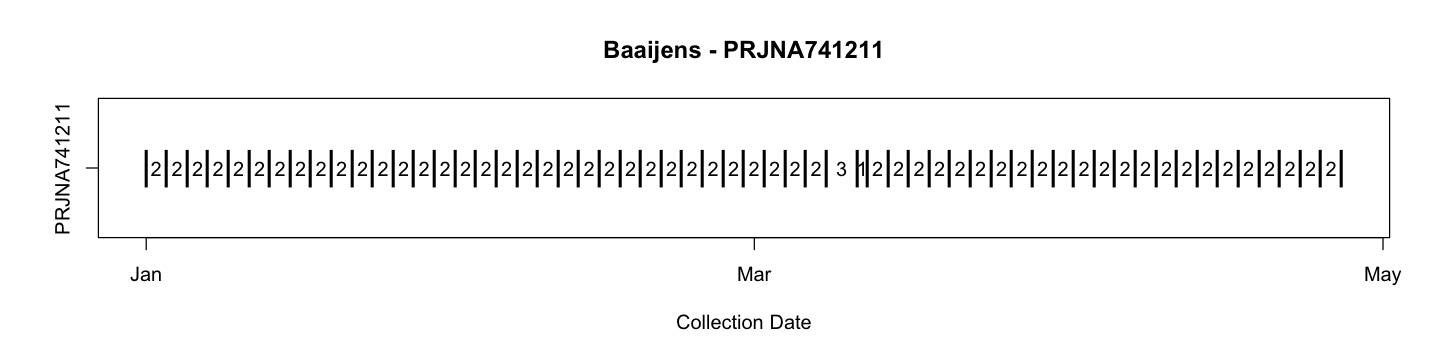

In [3]:
options(repr.plot.width=12, repr.plot.height=3)
diff_dates(baaijens, col = "BioProject", 
    xlab = "Collection Date", ylab = "", 
    main = "Baaijens - PRJNA741211")

Other than one sample that was a day late, there were always two time periods (days) between samples.

In [5]:
tic()
coco <- read.csv(here("data/processed/PRJNA741211_processed.csv.gz"))
coco$mutation <- parse_mutations(coco$label)
varmat <- full_varmat[rownames(full_varmat) %in% c("B.1.427", "B.1.429", "B.1.526", "B.1.1.7", "B.1.351", "B.1.525"), ]
fused <- fuse(coco, varmat, verbose = FALSE)
fused$sample <- fused$date
toc()

Warning message in fuse(coco, varmat, verbose = FALSE):
"Less than 0.0012326656394453% of coco's mutations are being used. Consider a larger variant matrix."


2.516 sec elapsed


In [6]:
tic()
provoc_res <- provoc(fused = fused, update_interval = 0, ncores = 4, verbose = FALSE)
toc()

4.892 sec elapsed


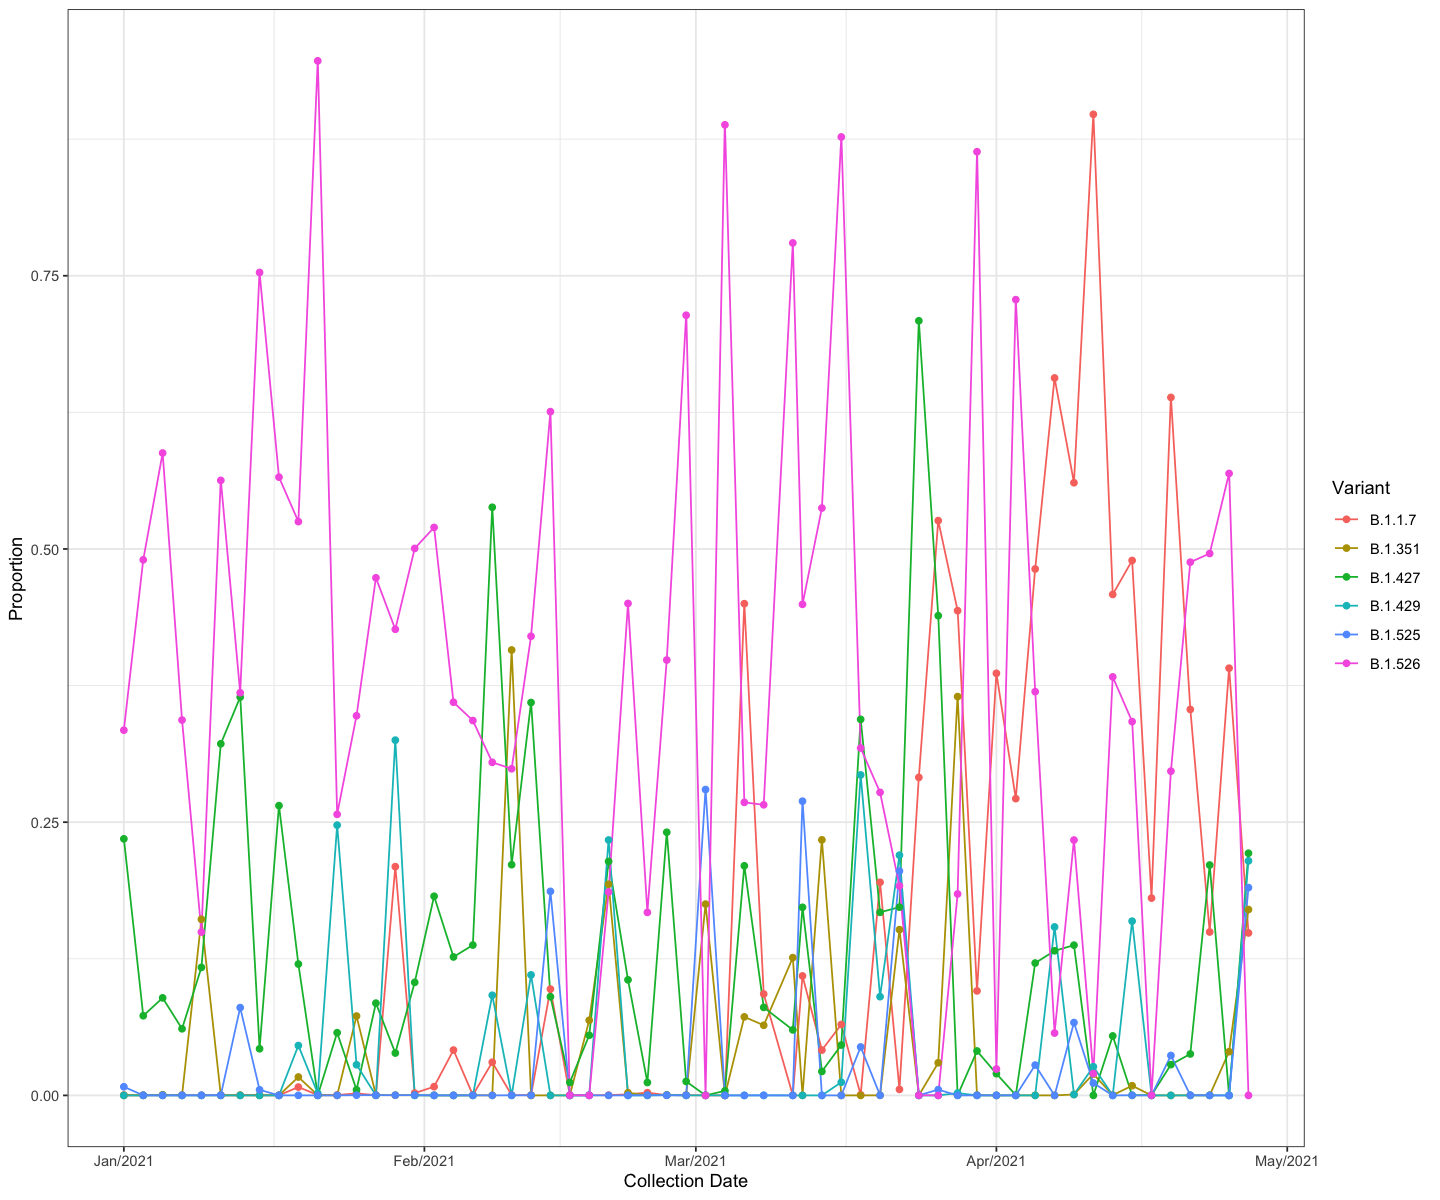

In [6]:
options(repr.plot.width=12, repr.plot.height=10)
ggplot(provoc_res) + 
    aes(x = ymd(sample), y = rho, colour = variant) + 
    geom_line() + geom_point() +
    labs(x = "Collection Date", y = "Proportion", 
        colour = "Variant") +
    scale_x_date(date_labels = "%b/%Y")

##### Conclusions

- One WWTP
- VERY regular sampling
- All estimates from ProVoC are pretty low, with no clear "dominant" lineage. 
    - These data are from early 2021, before variants were labelled as "variants of concern". 

### Jahn - PRJEB44932

In [7]:
jahn <- load_prj("PRJEB44932") |> rm_ones()
jahn$wwtp <- substr(jahn$geographic_location_.region_and_locality.,
    1, 2)
head(jahn)

,Run,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Collection_Date,DATASTORE.filetype,DATASTORE.provider,DATASTORE.region,⋯,INSDC_first_public,INSDC_last_update,Instrument,ReleaseDate,run_date..run.,Sample.Name,Sample_Name,Submitter_Id,geographic_location_.region_and_locality.,wwtp
,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ERR5922333,502,205750724,PRJEB44932,SAMEA8745890,89541277,2020-07-23,"cram,activ_sars2_vcf,sra","s3,gs","s3.us-east-1,gs.US",⋯,2021-05-17T12:31:43Z,2021-05-17T12:31:43Z,Illumina MiSeq,2021-05-19T00:00:00Z,2020-12-15,SAMEA8745890,10_2020_7_23,10_2020_7_23,ZH - Z<c3><bc>rich - ARA Werdh<c3><b6>lzli,ZH
2,ERR9861200,502,2778133762,PRJEB44932,SAMEA110148731,387121130,2021-11-24,"activ_sars2_vcf,cram,sra","gs,s3","s3.us-east-1,gs.US",⋯,2022-06-20T04:17:33Z,2022-06-20T04:17:33Z,Illumina NovaSeq 6000,2022-06-20T00:00:00Z,2021-12-10,SAMEA110148731,05_2021_11_24,05_2021_11_24,TI - Lugano - CDA Lugano,TI
3,ERR9861201,502,2566883126,PRJEB44932,SAMEA110148732,377298030,2021-11-25,"activ_sars2_vcf,cram,sra","gs,s3","gs.US,s3.us-east-1",⋯,2022-06-20T04:17:33Z,2022-06-20T04:17:33Z,Illumina NovaSeq 6000,2022-06-20T00:00:00Z,2021-12-10,SAMEA110148732,05_2021_11_25,05_2021_11_25,TI - Lugano - CDA Lugano,TI
4,ERR9861202,502,3277425974,PRJEB44932,SAMEA110148733,385574540,2021-11-26,"activ_sars2_vcf,sra,cram","gs,s3","gs.US,s3.us-east-1",⋯,2022-06-20T04:17:33Z,2022-06-20T04:17:33Z,Illumina NovaSeq 6000,2022-06-20T00:00:00Z,2021-12-10,SAMEA110148733,05_2021_11_26,05_2021_11_26,TI - Lugano - CDA Lugano,TI
5,ERR9861203,502,7853210190,PRJEB44932,SAMEA110148734,933771900,2021-11-27,"cram,sra,activ_sars2_vcf","gs,s3","s3.us-east-1,gs.US",⋯,2022-06-20T04:17:33Z,2022-06-20T04:17:33Z,Illumina NovaSeq 6000,2022-06-20T00:00:00Z,2021-12-10,SAMEA110148734,05_2021_11_27,05_2021_11_27,TI - Lugano - CDA Lugano,TI
6,ERR9861204,502,4232126562,PRJEB44932,SAMEA110148735,526575946,2021-11-28,"cram,sra,activ_sars2_vcf","s3,gs","s3.us-east-1,gs.US",⋯,2022-06-20T04:17:33Z,2022-06-20T04:17:33Z,Illumina NovaSeq 6000,2022-06-20T00:00:00Z,2021-12-10,SAMEA110148735,05_2021_11_28,05_2021_11_28,TI - Lugano - CDA Lugano,TI


In [8]:
table(jahn$wwtp)


     BE  GR  SG  Sk  TI  VD  ZH 
 15 304 290 299  10 301 239 365 

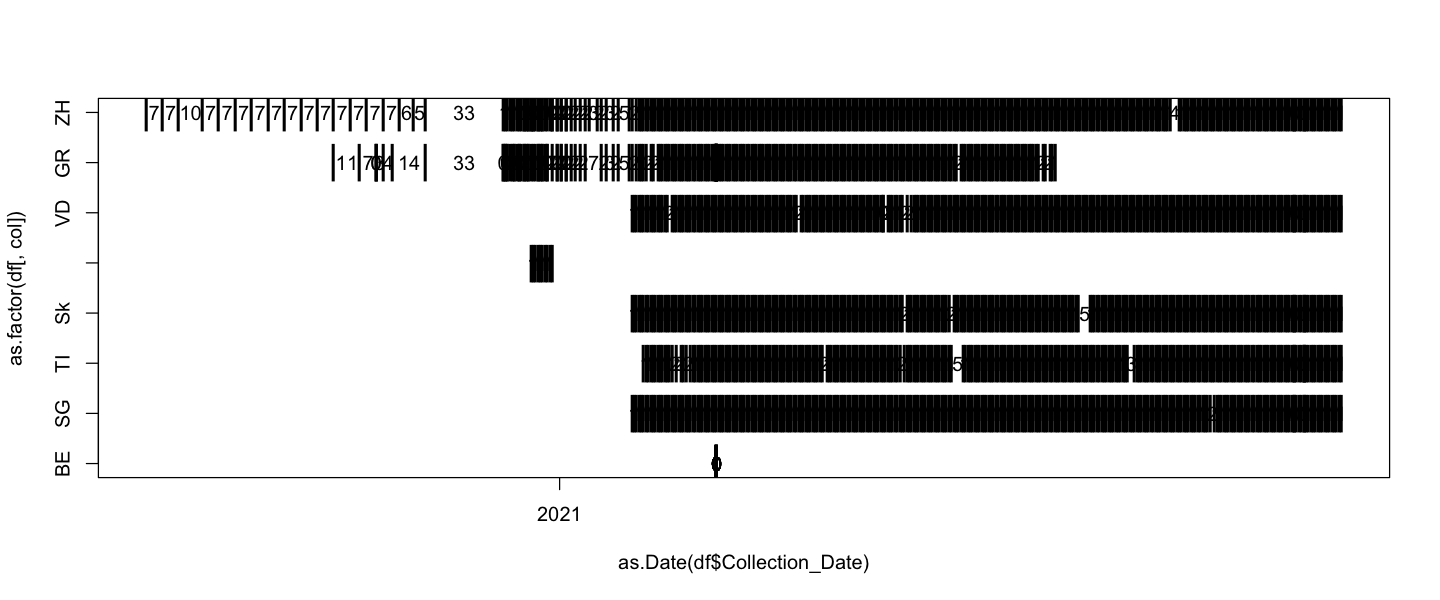

In [9]:
options(repr.plot.width=12, repr.plot.height=5)
diff_dates(jahn, "wwtp")

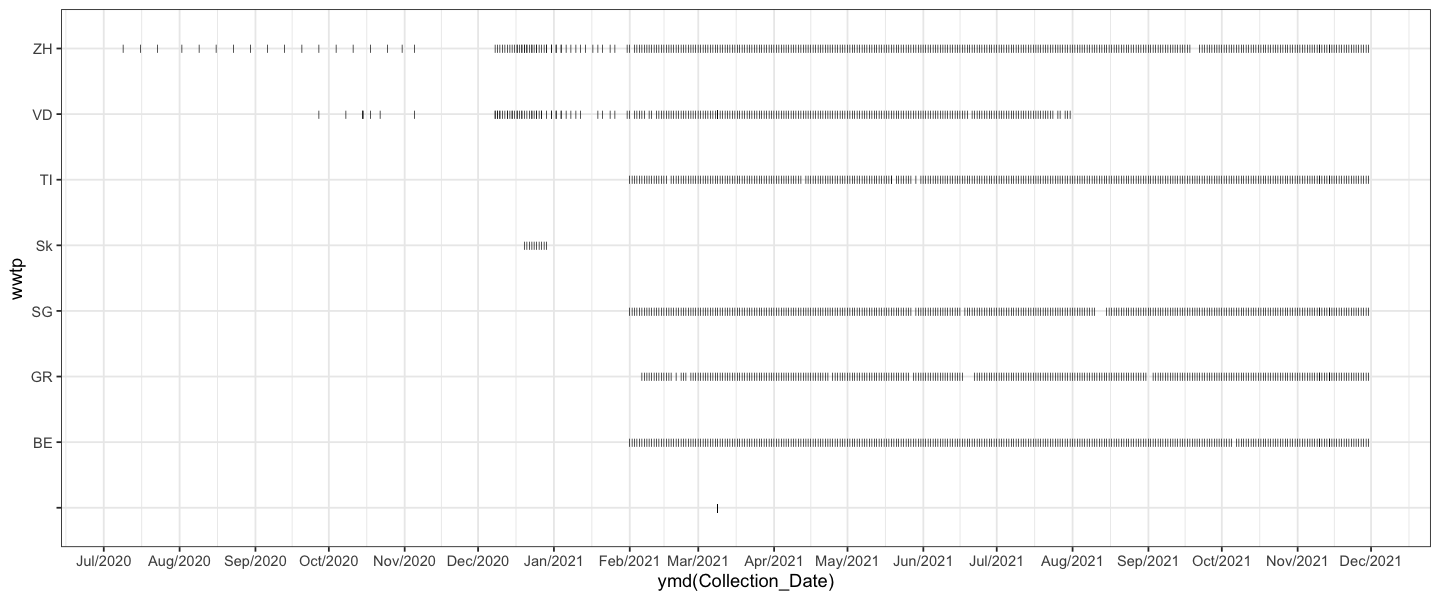

In [10]:
ggplot() +
    geom_point(data = jahn,
        mapping = aes(x = ymd(Collection_Date), y = wwtp),
        shape = "|") +
    scale_x_date(date_breaks = "1 month", date_labels = "%b/%Y")

In [ ]:
table_regularity(jahn$Collection_Date, jahn$wwtp) |> colnames() |> unlist()

- Heavy sampling from Feb 2021 to Dec 2021.
    - ZH has extra, with some weekly sampling prior to Feb.

### Preliminary Modelling

Loading in the data takes a long while, as you can see from `tictoc`.

In [12]:
tic()
coco <- read.csv(here("data/processed/PRJEB44932_processed.csv.gz"))
coco <- coco[coco$frequency > 0.01 & coco$coverage > 40, ]
toc()

805.378 sec elapsed


In [13]:
tic()
coco$mutation <- parse_mutations(coco$label)
toc()

87.369 sec elapsed


In [14]:
varmat <- full_varmat[rownames(full_varmat) %in% c("B.1.427", "B.1.429", "B.1.526", "B.1.1.7", "P.1", "P.2", "B.1.351", "B.1.525"), ]
fused <- fuse(coco, varmat, verbose = FALSE)
fused$sample <- fused$sra
fused <- fused %>%
    group_by(sample) %>%
    mutate(keep = rep(n() > 10, n())) %>%
    ungroup() %>%
    filter(keep) %>%
    select(-keep)

Warning message in fuse(coco, varmat, verbose = FALSE):
"Less than 0.000156439846271778% of coco's mutations are being used. Consider a larger variant matrix."


In [ ]:
tic()
provoc_res <- provoc(fused = fused, update_interval = 0, ncores = 4, verbose = FALSE)
toc()

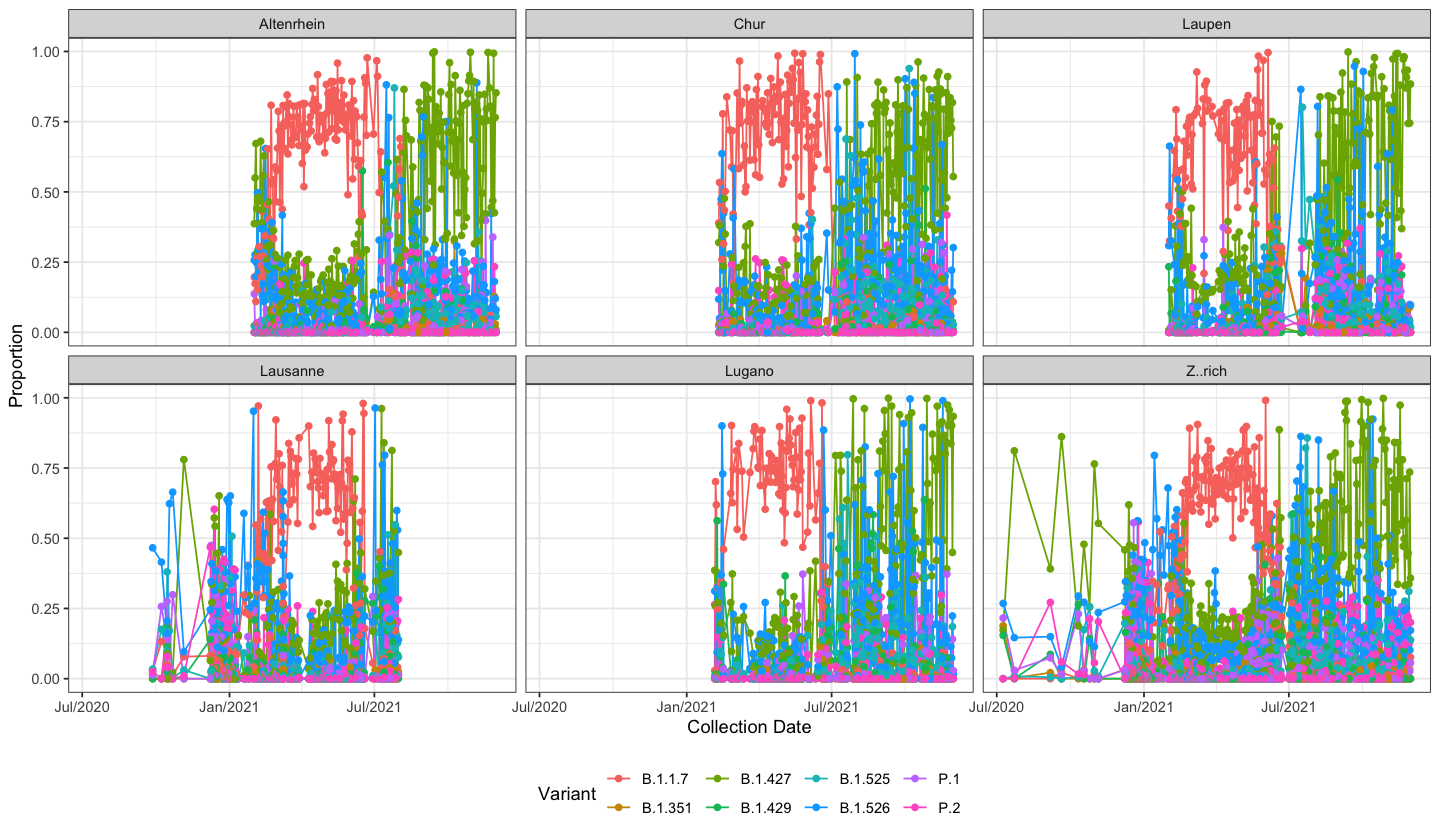

In [16]:
options(repr.plot.width=12, repr.plot.height=7)
ggplot(filter(provoc_res, !is.na(location))) + 
    aes(x = ymd(date), y = rho, colour = variant) + 
    facet_wrap(~ location) +
    geom_line() + geom_point() +
    labs(x = "Collection Date", y = "Proportion", 
        colour = "Variant") +
    scale_x_date(date_labels = "%b/%Y") +
    theme(legend.position = "bottom")

In [17]:
# Clean up - files are massive!
rm(coco)
rm(jahn)

# Karthykeyan - PRJEB48206

In [18]:
karthykeyan <- load_prj("PRJNA819090") |> rm_ones()
head(karthykeyan)

,Run,AvgSpotLen,Bases,BioProject,BioSample,Bytes,collection_date..run.,Collection_Date,DATASTORE.filetype,DATASTORE.provider,DATASTORE.region,Experiment,geo_loc_name,Isolation_Source,Library.Name,ReleaseDate,Sample.Name,Sample..run.,SAMPLE,ww_population
,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,SRR18543372,299,16187200,PRJNA819090,SAMN27108001,1651548,2021-06-27 00:00:00+00:00,2021-06-27,"bam,sra","s3,gs","s3.us-east-1,gs.US",SRX14673411,"USA: California\, UCSD Campus",campus sewage,SEARCH-42482,2022-03-31T00:00:00Z,SEARCH-42482,SEARCH-42482__E0000056__K01__210730_A00953_0364_BHGYJ7DSX2__001,SEARCH-42482__E0000056__K01__210730_A00953_0364_BHGYJ7DSX2__001,NA
2,SRR18543373,299,3209052,PRJNA819090,SAMN27108000,540381,2021-06-23 00:00:00+00:00,2021-06-23,"sra,bam","s3,gs","gs.US,s3.us-east-1",SRX14673410,"USA: California\, UCSD Campus",campus sewage,SEARCH-42477,2022-03-31T00:00:00Z,SEARCH-42477,SEARCH-42477__E0000056__P01__210730_A00953_0364_BHGYJ7DSX2__001,SEARCH-42477__E0000056__P01__210730_A00953_0364_BHGYJ7DSX2__001,NA
3,SRR18543374,299,9344031,PRJNA819090,SAMN27107999,1004979,2021-05-05 00:00:00+00:00,2021-05-05,"bam,sra","gs,s3","gs.US,s3.us-east-1",SRX14673409,"USA: California\, UCSD Campus",campus sewage,SEARCH-42476,2022-03-31T00:00:00Z,SEARCH-42476,SEARCH-42476__E0000056__J03__210730_A00953_0364_BHGYJ7DSX2__001,SEARCH-42476__E0000056__J03__210730_A00953_0364_BHGYJ7DSX2__001,NA
4,SRR18543375,300,4508256,PRJNA819090,SAMN27107998,553260,2021-05-30 00:00:00+00:00,2021-05-30,"activ_sars2_vcf,sra,bam","gs,s3","gs.US,s3.us-east-1",SRX14673408,"USA: California\, UCSD Campus",campus sewage,SEARCH-42475,2022-03-31T00:00:00Z,SEARCH-42475,SEARCH-42475__E0000056__N02__210730_A00953_0364_BHGYJ7DSX2__001,SEARCH-42475__E0000056__N02__210730_A00953_0364_BHGYJ7DSX2__001,NA
5,SRR18543376,299,7844378,PRJNA819090,SAMN27107997,931474,2021-05-30 00:00:00+00:00,2021-05-30,"sra,bam","s3,gs","s3.us-east-1,gs.US",SRX14673407,"USA: California\, UCSD Campus",campus sewage,SEARCH-42474,2022-03-31T00:00:00Z,SEARCH-42474,SEARCH-42474__E0000056__O02__210730_A00953_0364_BHGYJ7DSX2__001,SEARCH-42474__E0000056__O02__210730_A00953_0364_BHGYJ7DSX2__001,NA
6,SRR18543377,299,1214342,PRJNA819090,SAMN27107996,330557,2021-05-30 00:00:00+00:00,2021-05-30,"bam,sra","s3,gs","gs.US,s3.us-east-1",SRX14673406,"USA: California\, UCSD Campus",campus sewage,SEARCH-42473,2022-03-31T00:00:00Z,SEARCH-42473,SEARCH-42473__E0000056__J02__210730_A00953_0364_BHGYJ7DSX2__001,SEARCH-42473__E0000056__J02__210730_A00953_0364_BHGYJ7DSX2__001,NA


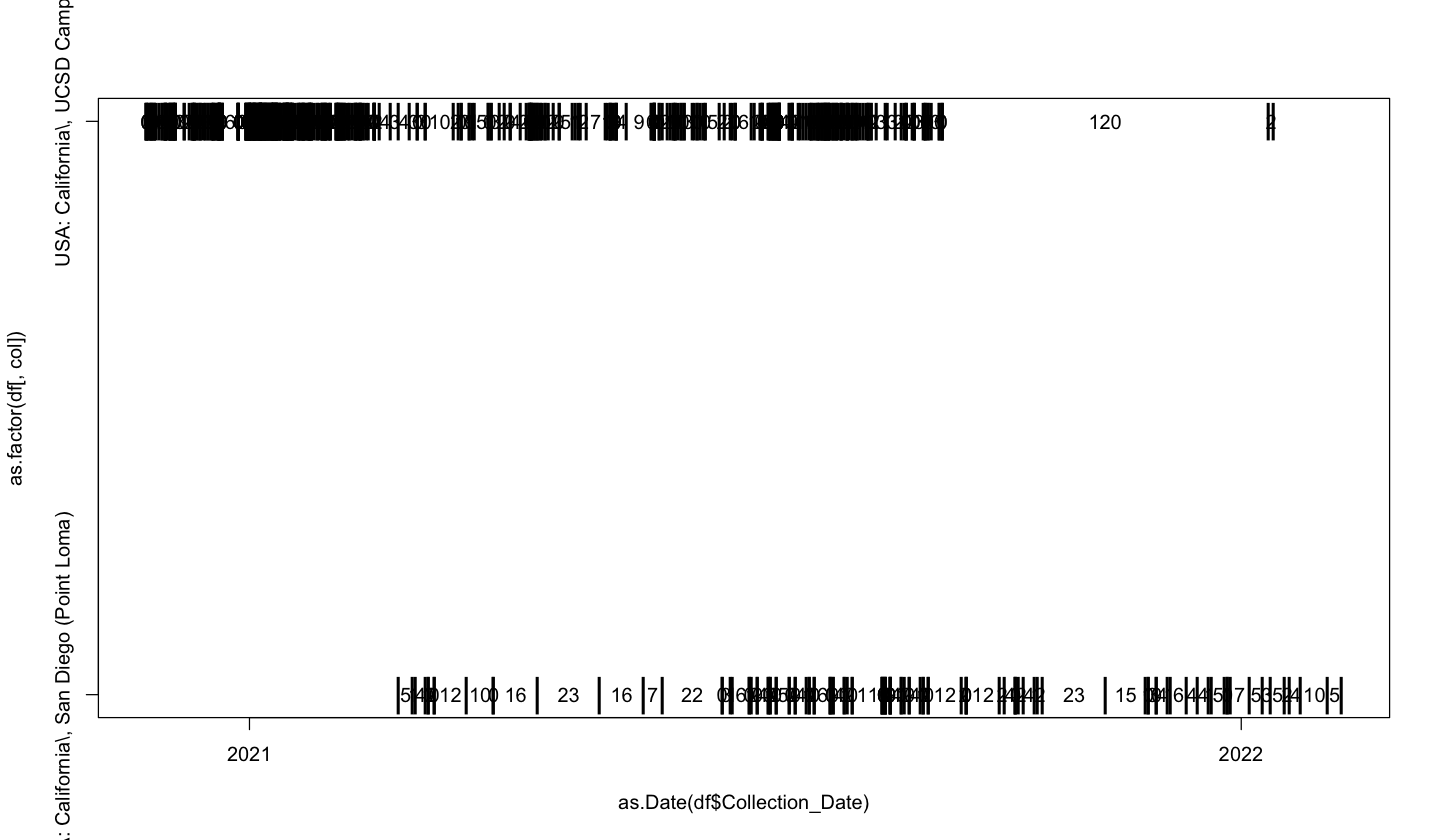

In [19]:
diff_dates(karthykeyan, "geo_loc_name")

In [ ]:
table_regularity(karthykeyan$Collection_Date, karthykeyan$geo_loc_name) |> colnames() |> unlist()


In [21]:
namesplit <- strsplit(karthykeyan$SAMPLE, split = "_") |>
    unlist() |>
    matrix(ncol = 12, byrow = TRUE)
#head(namesplit)
#table(namesplit[, 5], namesplit[, 7])
#table(namesplit[, 12], karthykeyan$geo_loc_name)

In [22]:
print(namesplit[1,]) # I have no idea what these mean.

 [1] "SEARCH-42482" ""             "E0000056"     ""             "K01"         
 [6] ""             "210730"       "A00953"       "0364"         "BHGYJ7DSX2"  
[11] ""             "001"         


In [23]:
tic()
coco <- read.csv(here("data/processed/PRJEB48206_processed.csv.gz"))
coco$mutation <- parse_mutations(coco$label)
varmat <- full_varmat[rownames(full_varmat) %in% c("B.1.427", "B.1.429", "B.1.526", "B.1.1.7", "B.1.351", "B.1.525"), ]
fused <- fuse(coco, varmat, verbose = FALSE)
fused$sample <- fused$sra
# There is a horribly mislabelled date.
fused <- fused[ymd(fused$date) > ymd("1905-07-13"), ]
toc()

Warning message in fuse(coco, varmat, verbose = FALSE):
"Less than 1.09561174790137e-05% of coco's mutations are being used. Consider a larger variant matrix."


188.976 sec elapsed


In [ ]:
tic()
provoc_res <- provoc(fused = fused, update_interval = 0, ncores = 4, verbose = FALSE)
toc()

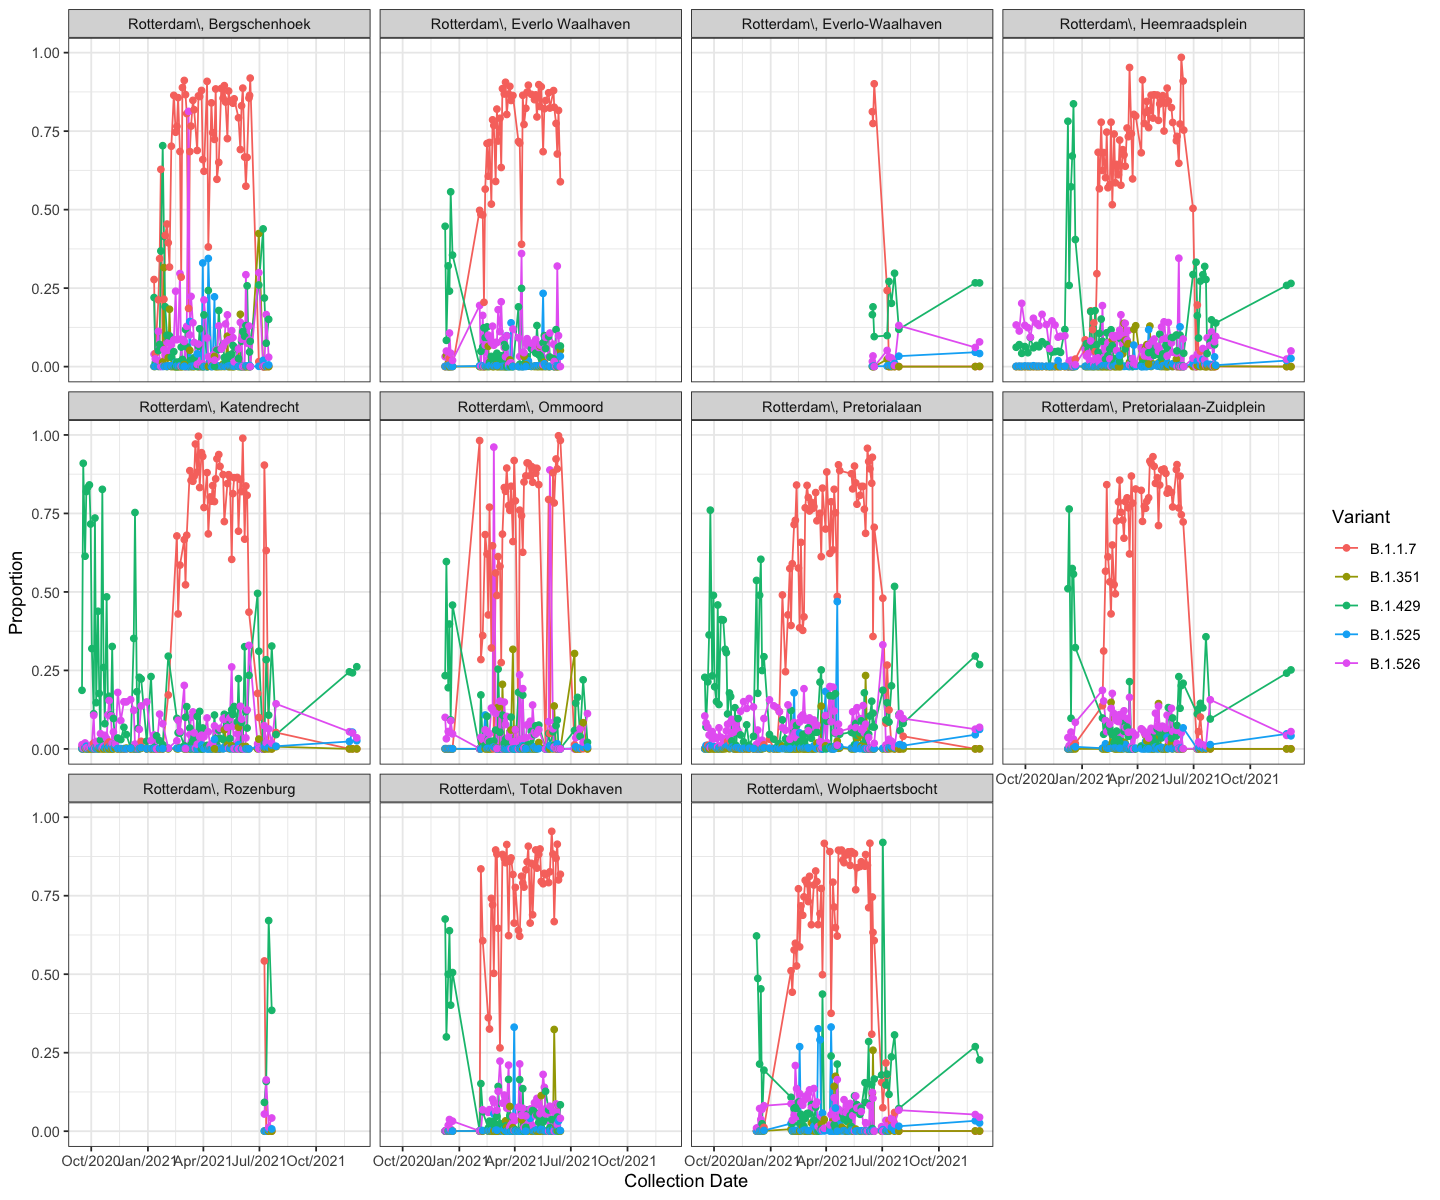

In [25]:
options(repr.plot.width=12, repr.plot.height=10)
ggplot(provoc_res) + 
    aes(x = ymd(date), y = rho, colour = variant) + 
    geom_line() + geom_point() +
    facet_wrap(~ wwtp) +
    labs(x = "Collection Date", y = "Proportion", 
        colour = "Variant") +
    scale_x_date(date_labels = "%b/%Y")